In [1]:
import cv2
import numpy as np

In [2]:
imori=cv2.imread("imori.jpg").astype(np.float32)
grayimori=cv2.cvtColor(imori.copy(),cv2.COLOR_BGR2GRAY).astype(np.float32)

In [3]:
def get_mask(img):
    output=img.copy()
    hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    ind=np.where((hsv[...,0]>=180) & (hsv[...,0]<=260))
    return ind
def mask_blue(img,ind):
    img[ind]=[0,0,0]
    return img.astype(np.uint8)

In [4]:
ans1=imori.copy()
ind=get_mask(ans1)
ans1=mask_blue(ans1,ind)
cv2.imwrite("ans1.jpg",ans1)

True

In [5]:
def Erode(img, Erode_time=1):
    H, W = img.shape
    out = img.copy()

    # kernel
    MF = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=np.int)

    # each erode
    for i in range(Erode_time):
        tmp = np.pad(out, (1, 1), 'edge')
        # erode
        for y in range(1, H + 1):
            for x in range(1, W + 1):
                if np.sum(MF * tmp[y - 1 : y + 2 , x - 1 : x + 2]) < 1 * 4:
                    out[y - 1, x - 1] = 0

    return out

def Dilate(img, Dil_time=1):
    H, W = img.shape

    # kernel
    MF = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=np.int)

    # each dilate time
    out = img.copy()
    for i in range(Dil_time):
        tmp = np.pad(out, (1, 1), 'edge')
        for y in range(1, H + 1):
            for x in range(1, W + 1):
                if np.sum(MF * tmp[y - 1 : y + 2, x - 1 : x + 2]) >= 1:
                    out[y - 1, x - 1] = 1

    return out

def Morphology_Opening(img, time=1):
    out = Erode(img, Erode_time=time)
    out = Dilate(out, Dil_time=time)
    return out

def Morphology_Closing(img, time=1):
    out = Dilate(img, Dil_time=time)
    out = Erode(out, Erode_time=time)
    return out

def masking(img,mask):
    ind=np.where(mask==1)
    img[ind]=[0,0,0]
    return img

def mask_and_morphology(img):
    H,W,C=img.shape
    ind=get_mask(img)
    mask=np.zeros((H,W),dtype=np.uint8)
    mask[ind]=255

    mask=Morphology_Closing(mask,time=5)
    mask=Morphology_Opening(mask,time=5)
    out=masking(img,mask)
    return out

In [6]:
ans2=imori.copy()
ans2=mask_and_morphology(ans2)
cv2.imwrite("ans2.jpg",ans2)

True

In [7]:
def bl_interpolate(img, ax=1., ay=1.):
    if len(img.shape) > 2:
        H, W, C = img.shape
    else:
        H, W = img.shape
        C = 1

    aH = int(ay * H)
    aW = int(ax * W)

    # get position of resized image
    y = np.arange(aH).repeat(aW).reshape(aW, -1)
    x = np.tile(np.arange(aW), (aH, 1))

    # get position of original position
    y = (y / ay)
    x = (x / ax)

    ix = np.floor(x).astype(np.int)
    iy = np.floor(y).astype(np.int)

    ix = np.minimum(ix, W-2)
    iy = np.minimum(iy, H-2)

    # get distance 
    dx = x - ix
    dy = y - iy

    if C > 1:
        dx = np.repeat(np.expand_dims(dx, axis=-1), C, axis=-1)
        dy = np.repeat(np.expand_dims(dy, axis=-1), C, axis=-1)

    # interpolation
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]

#     out = np.clip(out, 0, 255)
#     out = out.astype(np.uint8)

    return out

In [8]:
ans3=imori.copy()
gray=cv2.cvtColor(ans3,cv2.COLOR_BGR2GRAY).astype(np.float32)
tmp=bl_interpolate(gray,0.5,0.5)
output=bl_interpolate(tmp,2.,2.)
output=np.clip(output,0,255)
output=output.astype(np.uint8)
cv2.imwrite("ans3.jpg",output)

True

In [9]:
def diff_(img,diff):
    out=np.abs(img-diff).astype(np.float)
    
    out=out/np.max(out)*255
    
    return out.astype(np.uint8)

In [10]:
ans4=imori.copy()
ans4=cv2.cvtColor(ans4,cv2.COLOR_BGR2GRAY).astype(np.float32)
tmp=bl_interpolate(ans4.copy(),0.5,0.5)
output=bl_interpolate(tmp,2.,2.)
out=diff_(ans4,output)
cv2.imwrite("ans4.jpg",out)

True

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def Gaussian_pyramid(gray):
    pyramids=[]
    div=2.
    for i in range(6):
        div/=2.
        pyramids.append(bl_interpolate(gray,ax=div,ay=div))
    
    return pyramids

def show_pyramids(pyramids,fname):
    for i,img in enumerate(pyramids,1):
        cv2.imwrite("%s_%s.jpg" % (fname,i),img)
        plt.subplot(1,6,i)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.xticks(color='None')
        plt.yticks(color='None')
    plt.show()

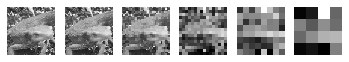

In [12]:
ans5=imori.copy()
ans5=cv2.cvtColor(ans5,cv2.COLOR_BGR2GRAY).astype(np.float32)
pyramids=Gaussian_pyramid(ans5)
show_pyramids(pyramids,'ans5')

In [13]:
def diff_images(img1,img2):
    output=np.abs(img1-img2)
    return output

def saliency_map(tmp):
    pyramids=[]
    ratio=0.5
    for i in tmp:
        ratio*=2.
        pyramids.append(bl_interpolate(i,ax=ratio,ay=ratio))
    
    indexs=[[0,1],[0,3],[0,5],[1,4],[2,3],[3,5]]
    sums=np.zeros_like(pyramids[0],dtype=np.float)
    for i,j in indexs:
#         print(pyramids[i].shape,pyramids[j].shape)
        sums+=diff_images(pyramids[i],pyramids[j])
    
    output=sums/np.max(sums)*255
    
    return output

In [14]:
pyramids=Gaussian_pyramid(grayimori.copy())
ans6=saliency_map(pyramids).astype(np.uint8)
cv2.imwrite("ans6.jpg",ans6)

True

In [15]:
def Gabor_filter(K=111,s=10.,g=1.2,l=10.,p=0.,A=0.):
    G=np.zeros((K,K),dtype=np.float)
    d=K//2
    
    for y in range(K):
        for x in range(K):
            theta=A/180.*np.pi
            dx=np.cos(theta)*(-d+x)+np.sin(theta)*(-d+y)
            dy=-np.sin(theta)*(-d+x)+np.cos(theta)*(-d+y)
            G[y,x]=np.exp(-(dx*dx+g*g*dy*dy)/(2*s*s))*np.cos(2*np.pi*dx/l+p)
            
    return G

In [16]:
ans7=Gabor_filter()
ans7=(ans7-np.min(ans7))/(np.max(ans7)-np.min(ans7))*255
cv2.imwrite("ans7.jpg",ans7.astype(np.uint8))

True

In [17]:
def rot_gabor():
    angles=np.arange(4)*45
    for i,A in enumerate(angles,1):
        out=Gabor_filter(A=A)
        out=((out-np.min(out))/(np.max(out)-np.min(out))*255).astype(np.uint8)
        cv2.imwrite("ans8_%s.jpg" % A,out)
        plt.subplot(1,4,i)
        plt.imshow(out,cmap='gray')
        plt.title("angle %s" % A)
        plt.axis("off")
        plt.xticks(color="None")
        plt.yticks(color="None")
    plt.show()

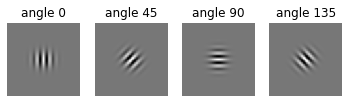

In [18]:
rot_gabor() # ans8

In [19]:
def Gabor_filtering(gray,K=111,s=10.,g=1.2,l=10.,p=0.,A=0.):
    H,W=gray.shape
    gray=np.pad(gray,(K//2,K//2),'edge')
    
    out=np.zeros((H,W),dtype=np.float32)
    gabor=Gabor_filter(K=K,s=s,g=g,l=l,p=p,A=A)
    
    for y in range(H):
        for x in range(W):
            out[y,x]=np.sum(gray[y:y+K,x:x+K]*gabor)
    
    out=np.clip(out,0,255).astype(np.uint8)
    
    return out

def process_for_ans9(gray):
    angles=np.arange(4)*45
    
    for i,A in enumerate(angles,1):
        out=Gabor_filtering(gray.copy(),K=11,s=1.5,g=1.2,l=3.,p=0.,A=A)
        cv2.imwrite("ans9_%s.jpg" % A, out)
        plt.subplot(1,4,i)
        plt.imshow(out,cmap='gray')
        plt.title("angle %s" % A)
        plt.axis('off')
        plt.xticks(color="None")
        plt.yticks(color="None")

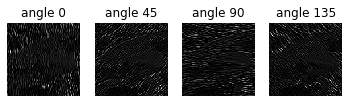

In [20]:
ans9=grayimori.copy()
process_for_ans9(ans9)

In [21]:
def extract_features_by_gabor(gray):
    angles=np.arange(4)*45
    
    output=np.zeros_like(gray,dtype=np.uint8)
    for i,A in enumerate(angles,1):
        tmp=Gabor_filtering(gray.copy(),K=11,s=1.5,g=1.2,l=3.,p=0.,A=A)
        output+=tmp
    output=np.clip(output/4.,0,255).astype(np.uint8)
    
    return output

In [22]:
ans10=grayimori.copy()
ans10=extract_features_by_gabor(ans10)
cv2.imwrite("ans10.jpg",ans10)

True